<a href="https://colab.research.google.com/github/Aisha-Hagar/FlowersClassification/blob/main/FlowersClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task Description**

Building a classification model using either a base model or a pre-trained model on this dataset.

Dataset Overview:
The dataset features 102 distinct flower categories, each containing between 40 to 258 images. These images showcase diverse characteristics encompassing scale, pose, lighting variations, and intra-category diversity. We've employed isomap visualization using shape and color features for a comprehensive dataset perspective.

Dataset Link: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

Submission Details:
Conduct your analysis and insights derivation based on the provided dataset.

# **Setup**

In [1]:
import urllib
import tarfile
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import random
from shutil import copyfile, rmtree
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from skimage import io
from PIL import Image
from keras.optimizers import RMSprop, schedules

In [2]:
#Set the seeds to get reproducible results
np.random.seed(1234)
random.seed(95)
keras.utils.set_random_seed(486)

# **Load Data**

In [3]:
#The images and the labels are stored in seperate files.
#Retrieve the Flowers dataset images and labels from the links provided on the website: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
data_url='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
labels_url='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'

urllib.request.urlretrieve(data_url, filename='data.tgz')
urllib.request.urlretrieve(labels_url, filename='labels.mat')

#Extract the retrieved .tgz file
file = tarfile.open('data.tgz')
file.extractall()
file.close()

In [4]:
#The labels are stored in .mat file.
#loadmat() reads the .mat file in form of dict.
#Check dictionary keys to find where the labels are stored.
labels_mat = loadmat('labels.mat')
labels_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels'])

In [5]:
labels_mat['labels']

array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)

In [6]:
labels_mat['labels'].shape

(1, 8189)

There is a total of 8189 images.

In [7]:
def plot_bar(x, y, xlabel, ylabel, title):
  plt.figure(figsize=(30, 10))
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title)
  sns.barplot(x = x, y = y)
  plt.show()

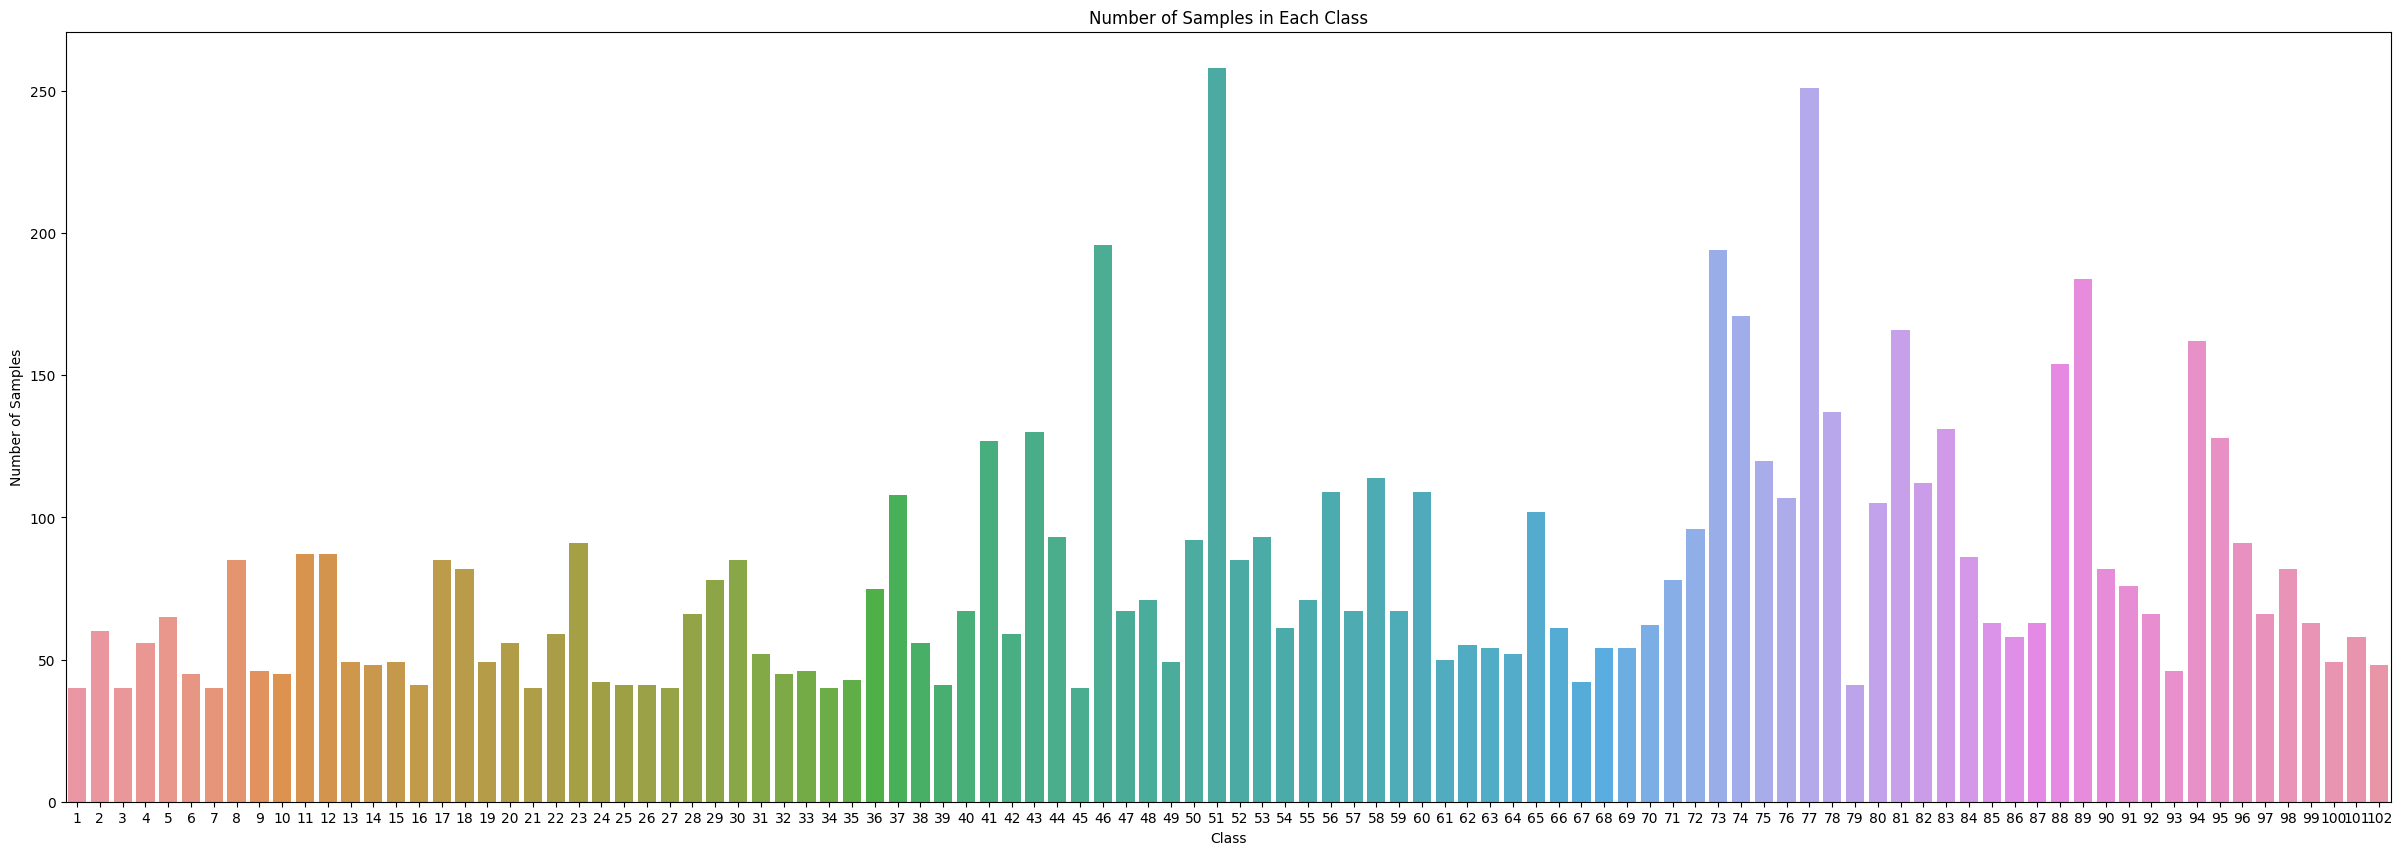

In [8]:
#To have a better understanding of the data distribution, plot the number of images in each class
unique, counts = np.unique(labels_mat['labels'], return_counts=True)
np.asarray((unique, counts)).T
plot_bar(unique, counts, 'Class', 'Number of Samples', 'Number of Samples in Each Class')

There are 102 classes with varying number of images in each class. The plot shows that the data is highly imbalanced.

In [9]:
#Get the names of the images and sort them to match the labels.
files=os.listdir('jpg')
files.sort()
len(files)

8189

In [10]:
#Create a dataframe to store the image name and lable because the data will be split and shuffled.
df = pd.DataFrame()
df['image_id']=files
df['label']=labels_mat['labels'].T
df

,image_id,label
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77
...,...,...
8184,image_08185.jpg,62
8185,image_08186.jpg,62
8186,image_08187.jpg,62
8187,image_08188.jpg,62


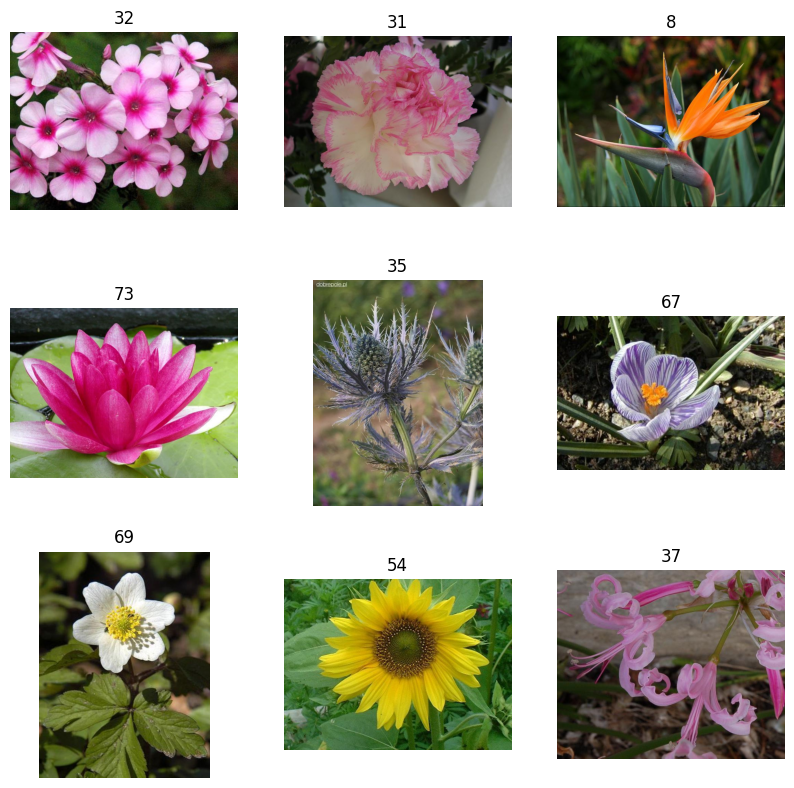

In [11]:
#Plot random samples form the dataset
plt.figure(figsize=(10, 10))
i=0
for index, row in df.sample(frac=1).iterrows():
    ax = plt.subplot(3, 3, i+1)
    path = os.path.join('jpg',row['image_id'])
    image = Image.open(path)
    plt.imshow(np.array(image).astype("uint8"))
    plt.title(row['label'])
    plt.axis("off")
    i+=1
    if i>8:
      break

# **Prepare Folders**

To avoid crashing of the session, load and process the images in batches. To do so, first, store the images of each class in a seperate folder.

In [12]:
def create_folders(path):
  try:
    os.makedirs(path)
  except FileExistsError:
    pass

In [13]:
#Create train, validation and test folders each with a subfolders for each class
for i in unique:
  i=str(i)
  create_folders(i)
  create_folders('train/'+i)
  create_folders('val/'+i)
  create_folders('test/'+i)
  for c in list(df[df['label']== int(i)]['image_id']):
    this_image = 'jpg/' + c
    copyfile(this_image, os.path.join(i,c))

rmtree('jpg/', ignore_errors=False, onerror=None)

# **Splitting Data**

To load the data in batches, each class has to be in a seperate folder in the train, validaition and test folders.

In [14]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE_TRN):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE,filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE_TRN)
    validation_length = testing_length = int((len(files) - training_length)/2)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    testing_set = shuffled_set[training_length+validation_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE,filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = os.path.join(SOURCE,filename)
        destination = os.path.join(VALIDATION, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE,filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)


In [15]:
def class_split(classes, split_size):
  for c in classes:
    c = str(c)
    SOURCE_DIR = c
    TRAINING_DIR = os.path.join('train/', c)
    VALIDATION_DIR = os.path.join('val/', c)
    TESTING_DIR = os.path.join('test/', c)
    split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, split_size)

In [16]:
#Split the data with ratio train: validation: test --> 0.8: 0.1: 0.1
class_split(unique, .8)

In [17]:
#After making sure the data was split and copied to 'train', 'val' and 'test' folders, delete the original data folders.
for i in range(1, 103, 1):
  rmtree(str(i), ignore_errors=False, onerror=None)

# **Data Generator**

In [18]:
batch_size = 32
img_height = 224
img_width = 224

In [19]:
#Create ImageDataGenerator to load the data in batches.
#Set the target_size to (224, 224) as the input shape of the model is (224, 224, 3).
#For the train dataset shuffle is set to True.
#For the valiadtion and test dataset shuffle is set to False to keep track of the the labels for performance evaluation.
#Set class_mode to 'categorical' to onehot encode the labels.
datagen = ImageDataGenerator()
train_dir = 'train/'
train_generator = datagen.flow_from_directory(train_dir,
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              target_size=(img_height, img_width),
                                              shuffle=True)

val_dir = 'val/'
val_generator = datagen.flow_from_directory(val_dir,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            target_size=(img_height, img_width),
                                            shuffle=False)

test_dir = 'test/'
test_generator = datagen.flow_from_directory(test_dir,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             target_size=(img_height, img_width),
                                             shuffle=False)

Found 6507 images belonging to 102 classes.
Found 816 images belonging to 102 classes.
Found 866 images belonging to 102 classes.


# **Model 1**

In [20]:
#Load ResNet50 model with 'imagenet' weights.
#Set include_top to False to later add final layers for feature extraction for the Flowers dataset.
base_model = ResNet50(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [21]:
#Create the model which consists of ResNet50 model followed by Flatten layer then a dense layer of 102 nodes and 'softmax' activation function.
model_1 = Sequential(
    [
        base_model,
        Flatten(),
        Dense(102, activation = 'softmax')
    ]
)

#Freez the weights of ResNet50.
model_1.layers[0].trainable = False
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 102)               10236006  
                                                                 
Total params: 33823718 (129.03 MB)
Trainable params: 10236006 (39.05 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [22]:
#Set the loss function to 'categorical_crossentropy' because the labels are onehot encoded.
#Use 'adam' optimizer as it is fast to converge.
model_1.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [23]:
epochs = 25

In [24]:
history_1 = model_1.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator)

Epoch 1/25
204/204 [==============================] - 41s 142ms/step - loss: 11.5449 - accuracy: 0.6444 - val_loss: 6.0023 - val_accuracy: 0.7904
Epoch 2/25
204/204 [==============================] - 28s 137ms/step - loss: 1.4671 - accuracy: 0.9304 - val_loss: 7.9882 - val_accuracy: 0.7757
Epoch 3/25
204/204 [==============================] - 28s 136ms/step - loss: 0.8413 - accuracy: 0.9608 - val_loss: 7.2771 - val_accuracy: 0.8015
Epoch 4/25
204/204 [==============================] - 27s 133ms/step - loss: 0.5955 - accuracy: 0.9716 - val_loss: 7.8110 - val_accuracy: 0.7978
Epoch 5/25
204/204 [==============================] - 27s 133ms/step - loss: 0.5797 - accuracy: 0.9736 - val_loss: 9.5421 - val_accuracy: 0.7929
Epoch 6/25
204/204 [==============================] - 28s 136ms/step - loss: 0.5533 - accuracy: 0.9730 - val_loss: 11.2484 - val_accuracy: 0.7806
Epoch 7/25
204/204 [==============================] - 28s 134ms/step - loss: 0.6351 - accuracy: 0.9799 - val_loss: 10.1052 - val

In [25]:
def plot_learning_curves(history, model_name):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title(model_name+' accuracy')
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'validation'], loc='upper right')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title(model_name+' loss')
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'validation'], loc='upper right')

  plt.show()

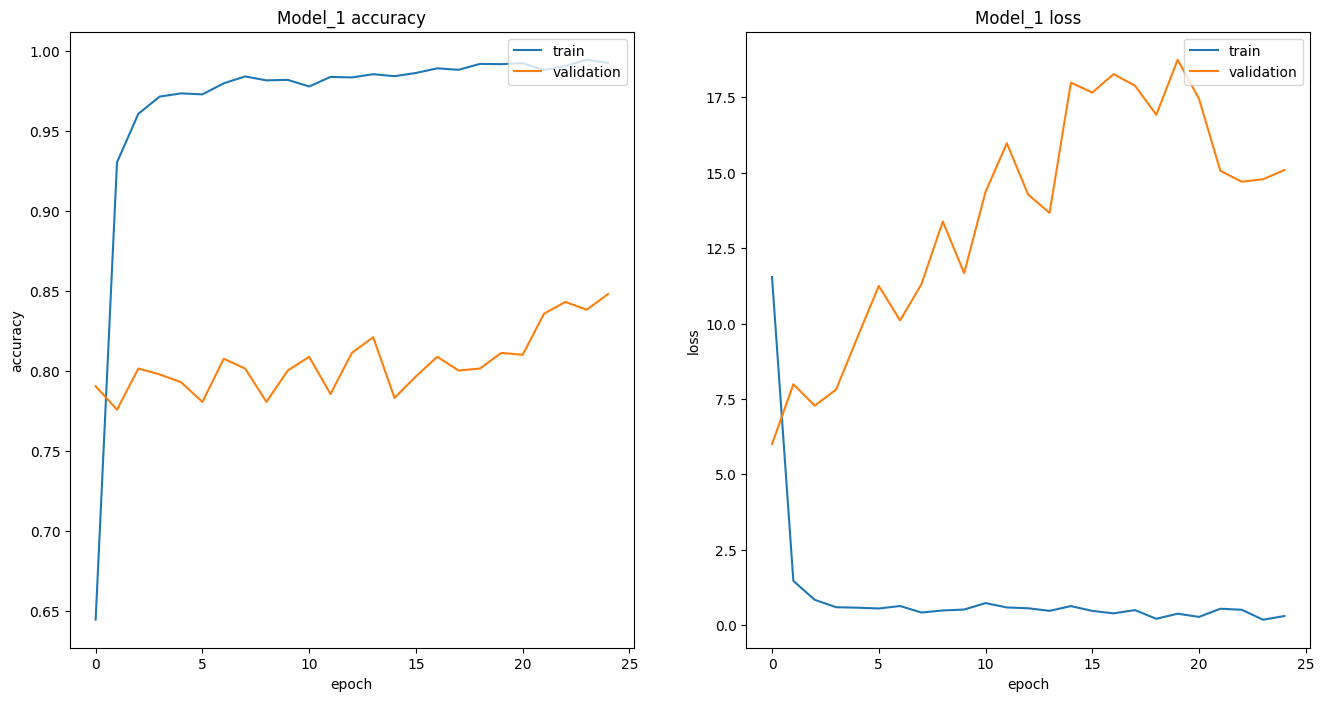

In [26]:
plot_learning_curves(history_1, 'Model_1')

From the learning curves we see that the validation curves are fluctuating strongly. For the validation dataset, the accuracy curve is barely improving and the loss is increasing. The graphs show the model is overfitting.

In [27]:
#Predict the labels of validation images
Y_pred1 = model_1.predict(val_generator)
y_pred1 = np.argmax(Y_pred1, axis=1)
y_pred1

26/26 [==============================] - 4s 107ms/step


array([ 66,   0,  87,  87,   1,   1,   1,   1,   2,   2,   2,   2,   2,
         3,  92,   3,  84,   3,  99,   4,   4,   4,   4,   4,  99,   3,
        40,  91,  25,  91,  97,  49,   5,   6,  95,   6,   6,   6,   6,
         6,   6,   6,   7,   7,   7,   7,   7,   8,   8,   8,  77,   8,
         9,   9,   9,  39,  39,  10,  99,  10,  10,  11,  11,  11,  11,
        11,  11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  66,
        13,  13,  13, 100,  14,  14,  14,  14,  14,  14,  15,  15,  15,
        66,  15,  15,  16,  16,  16,  16,  17,  17,  17,  17,  17,  17,
        18,  18,  18,  81,  18,  18,  18,  18,  18,  19,  19,  19,  19,
        20,  20,  20,  20,  37,  99,  99,  21,  22,  22,  22,  22,  23,
        37,  25,  23,  23,  23,  23,  24,  24,  24,  24,  24,  24,  24,
        24,  83,  29,  25,  25,  77,  26,  26,  26,  26,  26,  26,  26,
        27,  27,  27,  27,  27,  25,  28,  28,  28,  29,  29,  29,  29,
        29,  29,  30,  30,  87,  77,  31,  31,  31,  86,  32,  3

In [28]:
#The predictions are onehot encoded.
#Convert the prediction to the labels.
#The labels and their encoding are stored as a dict in the attribute class_indices
val_dict=val_generator.class_indices
val_dict = dict((v,k) for k,v in val_dict.items())
val_preds1=[val_dict[k] for k in y_pred1]
val_true=[val_dict[k] for k in val_generator.classes]

##**Model 1 Performance Evaluation**

In [29]:
#Get names of classes
val_target_names = list(val_generator.class_indices.keys())

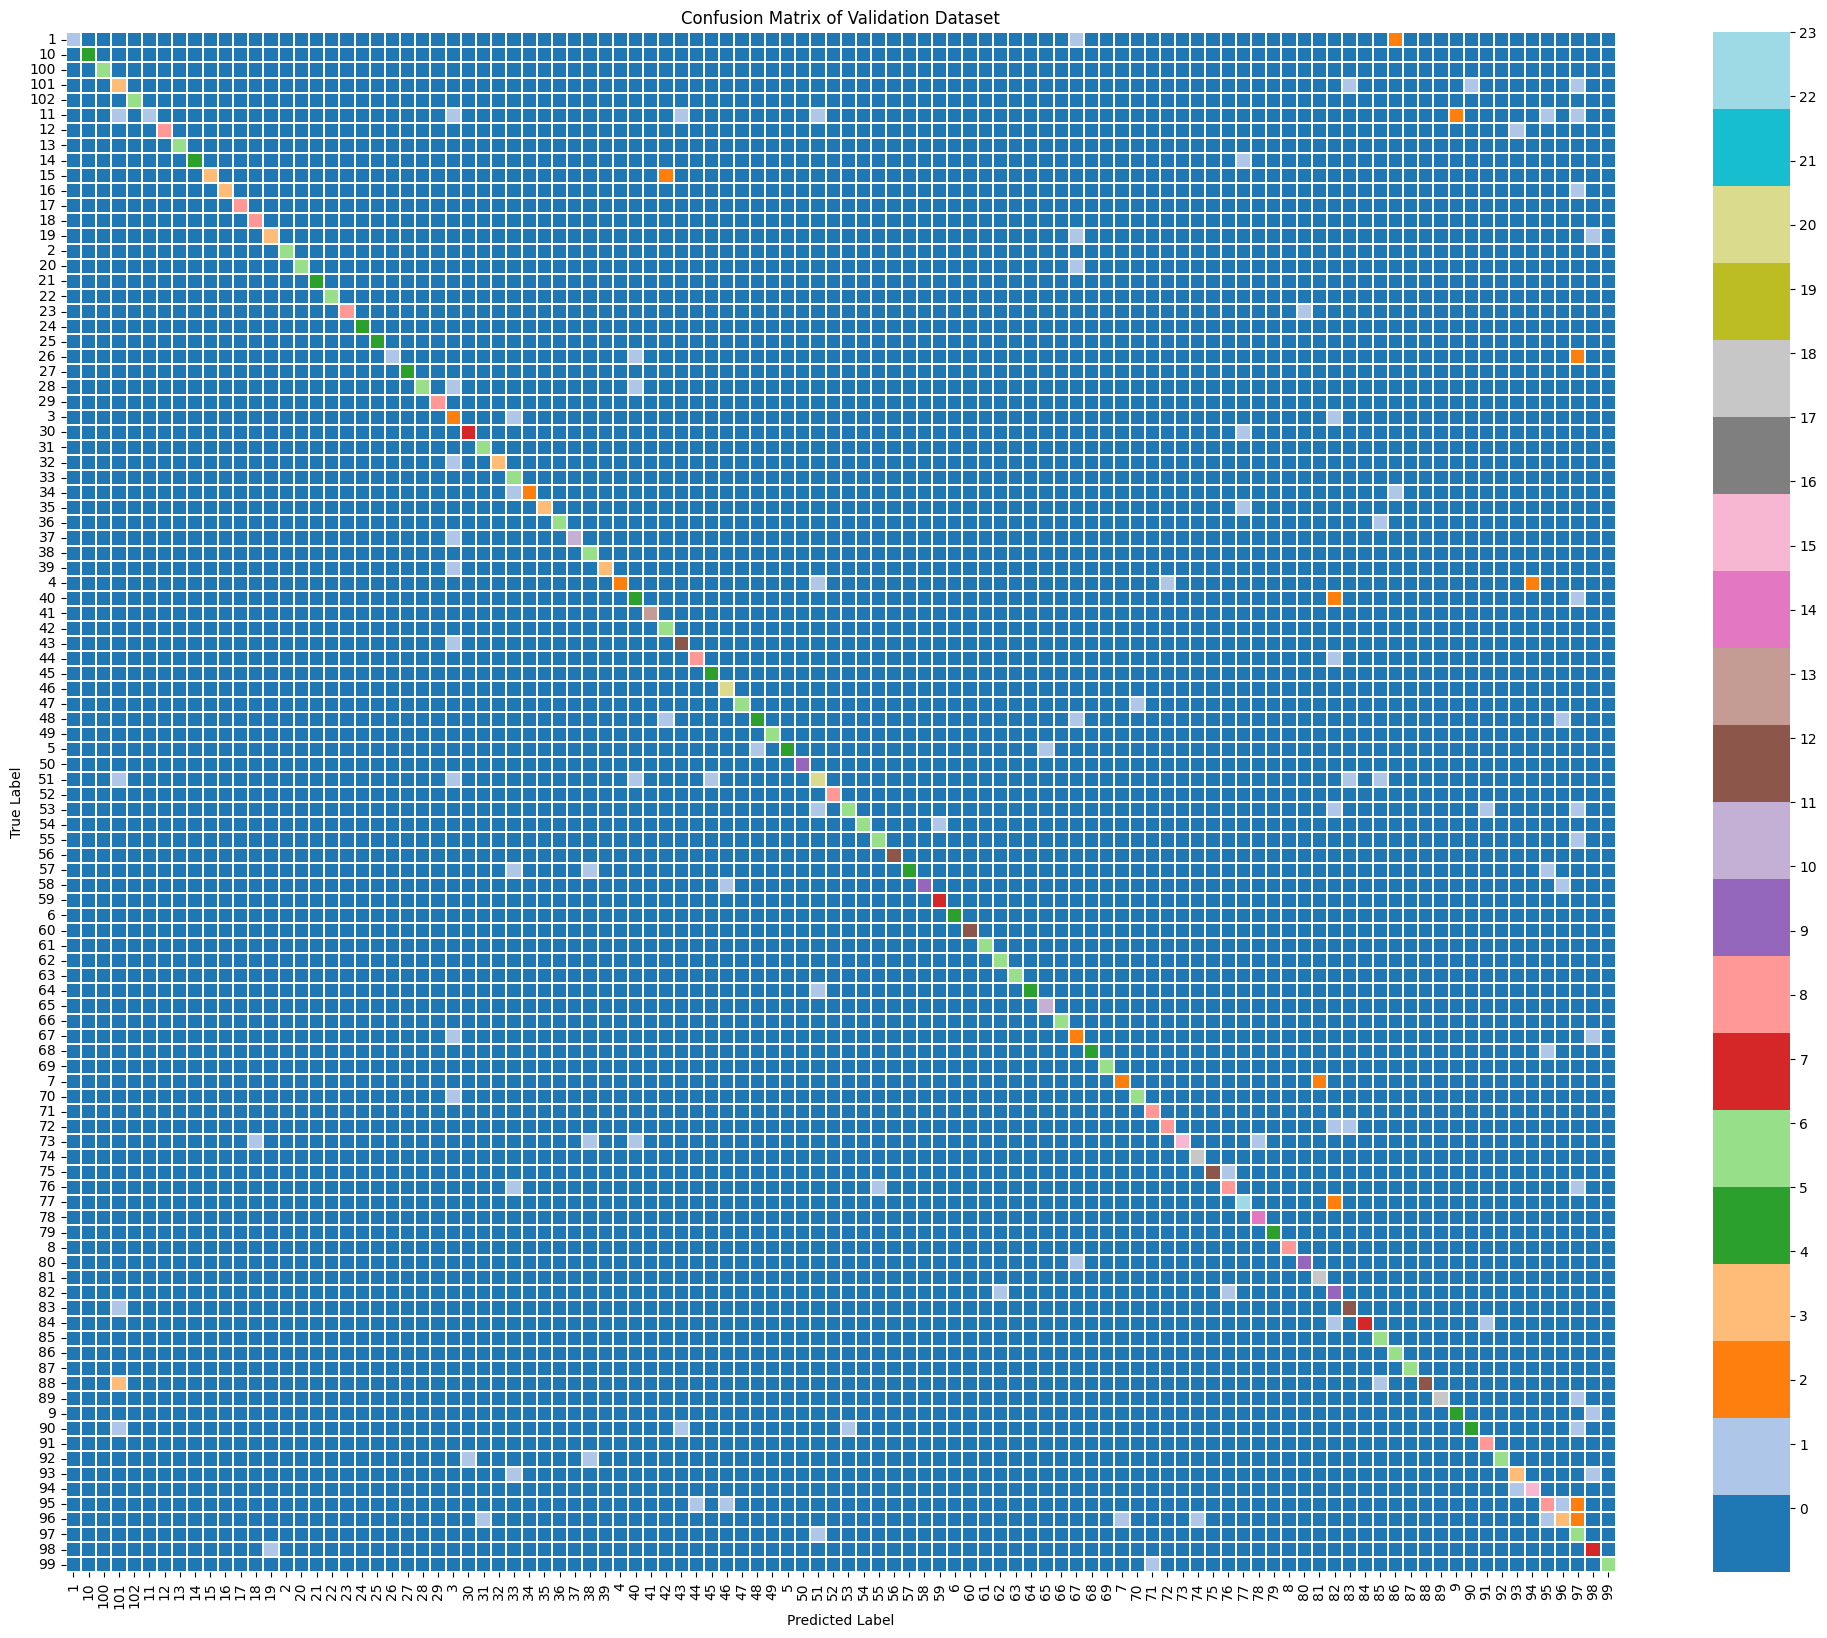

In [30]:
#Plot confusion matrix
confmat = confusion_matrix(val_true,val_preds1)
plt.figure(figsize = (25,20))
confmat_plot=sns.heatmap(confmat, vmin=-1, vmax=np.amax(confmat), cmap=sns.color_palette("tab20", as_cmap=True), linewidths=0.004, cbar_kws={'ticks':range(0,np.amax(confmat)+1,1)}, xticklabels=val_target_names, yticklabels=val_target_names)
confmat_plot.set(xlabel ='Predicted Label', ylabel = 'True Label', title ='Confusion Matrix of Validation Dataset')
plt.show()

Since there is a large number of classes, the confusion matrix is not very clear. We can still see that there misclassification for several classes. A better method for performance evaluation is to check performance metrics by printing the classificaiton report.  

In [31]:
#Print classification report.
#Set zero_division to zero, which means no warning will appear and f1_score will be set to zero in the case of no correct classifications for any of the classes.
print(classification_report(val_true, val_preds1, target_names=val_target_names, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      0.25      0.40         4
          10       1.00      1.00      1.00         4
         100       1.00      1.00      1.00         5
         101       0.30      0.50      0.37         6
         102       1.00      1.00      1.00         5
          11       1.00      0.11      0.20         9
          12       1.00      0.89      0.94         9
          13       1.00      1.00      1.00         5
          14       1.00      0.80      0.89         5
          15       1.00      0.60      0.75         5
          16       1.00      0.75      0.86         4
          17       1.00      1.00      1.00         8
          18       0.89      1.00      0.94         8
          19       0.75      0.60      0.67         5
           2       1.00      1.00      1.00         6
          20       1.00      0.83      0.91         6
          21       1.00      1.00      1.00         4
          22       1.00    

The accuracy of Model_1 on the validation dataset is 85%. Since the data is highly imbalanced, it is better to focus on the f1_score. The f1_score for Model_1 is 84%.

# **Data Augmentation**

An approach to improve the model's performance is to reduce the high imbalance in the data through data augmentation.

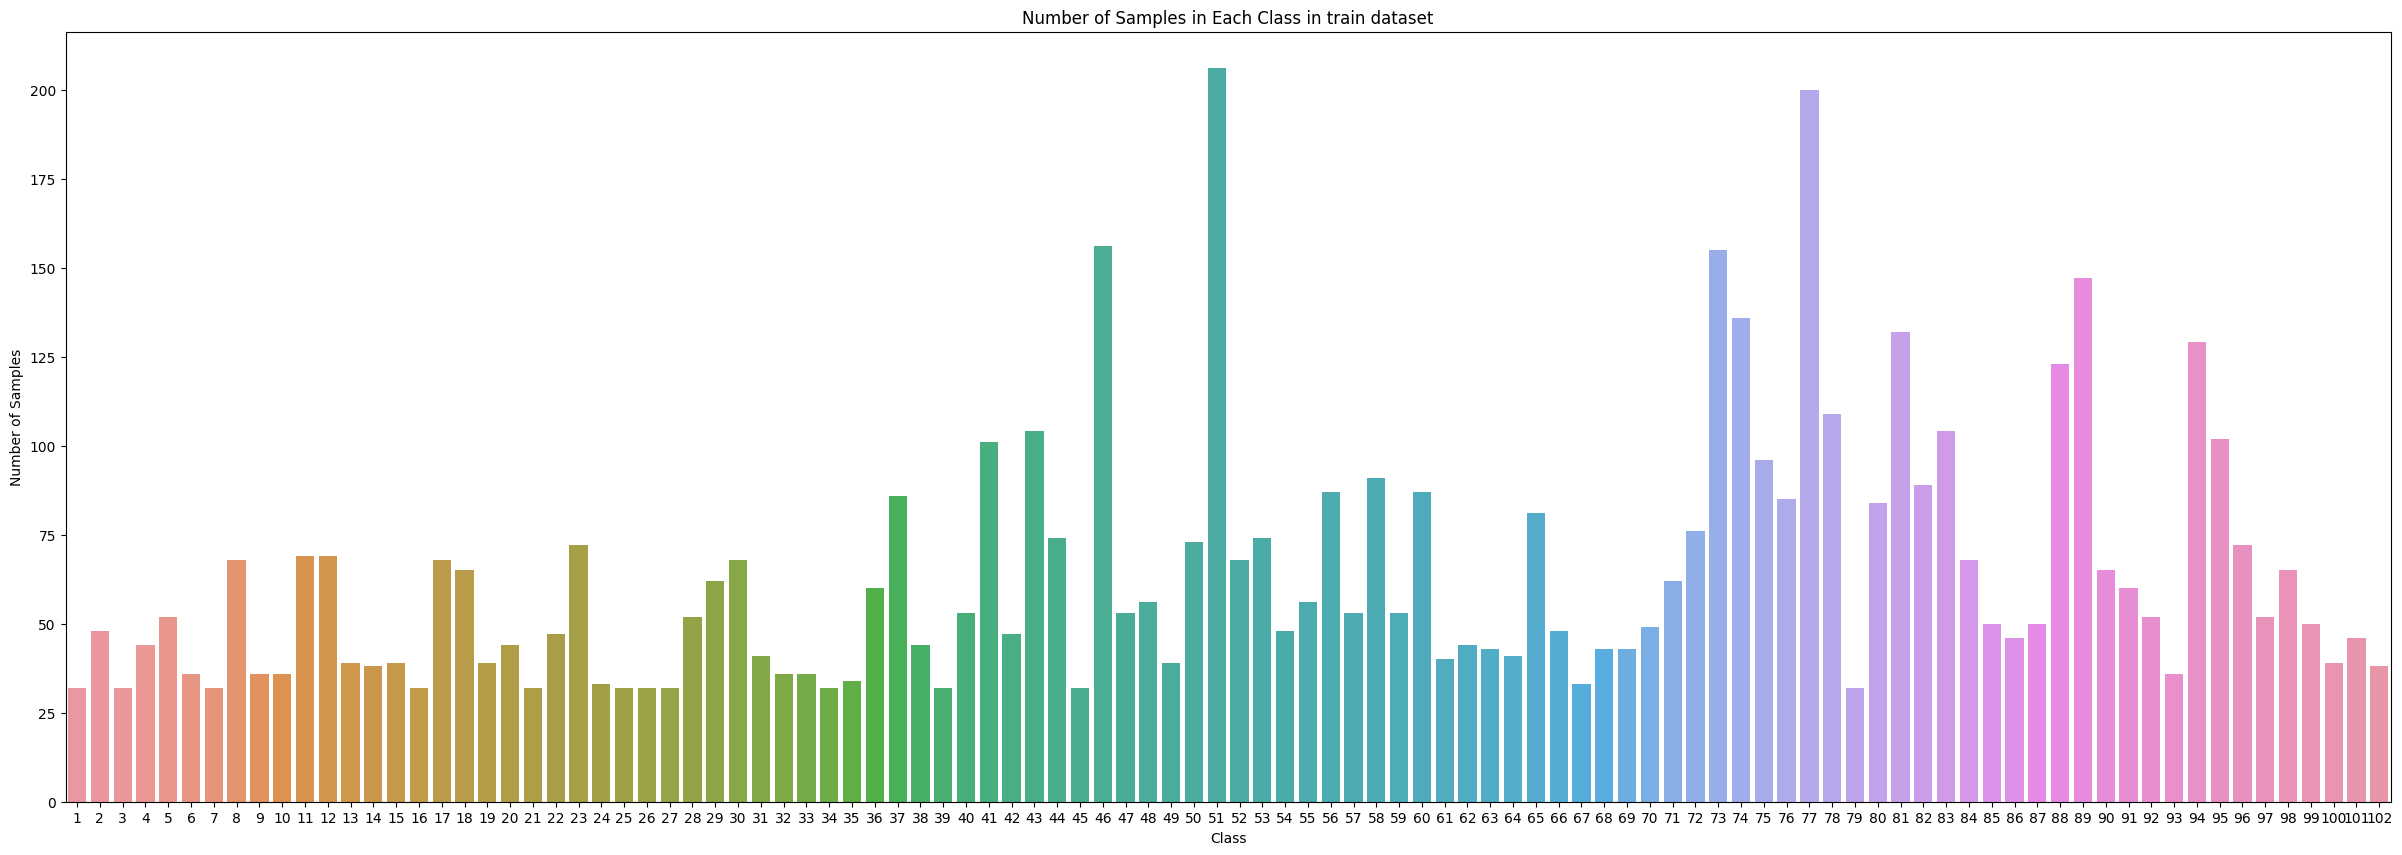

In [32]:
#Check the distribution of the data in train dataset.
train_data={}
for i in range(1,103,1):
  train_data[i] = len(os.listdir('train/'+str(i)))

plot_bar(list(train_data.keys()), list(train_data.values()), 'Class', 'Number of Samples', 'Number of Samples in Each Class in train dataset')

In [33]:
#Create an ImageDataGenerator to augment the train data.
#Data augmentation techniques: horizontal and vertical flipping, rotation, brightness, zooming.
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    brightness_range=[0.1,2.0],
    zoom_range=[0.3,1])

In [34]:
def augment_images(img_dir, generator):
  dataset = []
  my_images = os.listdir(img_dir)
  for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
      image = io.imread(os.path.join(img_dir,image_name))
      image = Image.fromarray(image, 'RGB')
      image = image.resize((img_height, img_width))
      dataset.append(np.array(image))
  x = np.array(dataset)
  i = 0
  for batch in generator.flow(x, batch_size=2,
                                save_to_dir= img_dir,
                                save_prefix='aug',
                                save_format='jpg'):
                                i += 1
                                if i > 30:
                                  break

In [35]:
#Augment images for minority classes only.
#Minority classes are the classes with less than 150 images.
sorted_train_data = sorted(train_data.items(), key=lambda x:x[1], reverse=True)
converted_dict = dict(sorted_train_data)
classes = list(filter(lambda x: converted_dict[x] > 150, converted_dict))
classes

[51, 77, 46, 73]

In [36]:
aug_images = []
for i in range(1,103,1):
  if(i not in classes):
    augment_images(os.path.join('train',str(i)), train_datagen)
    for image in os.listdir(os.path.join('train',str(i))):
      if(image.startswith('aug')):
        aug_images.append(os.path.join('train',str(i), image))

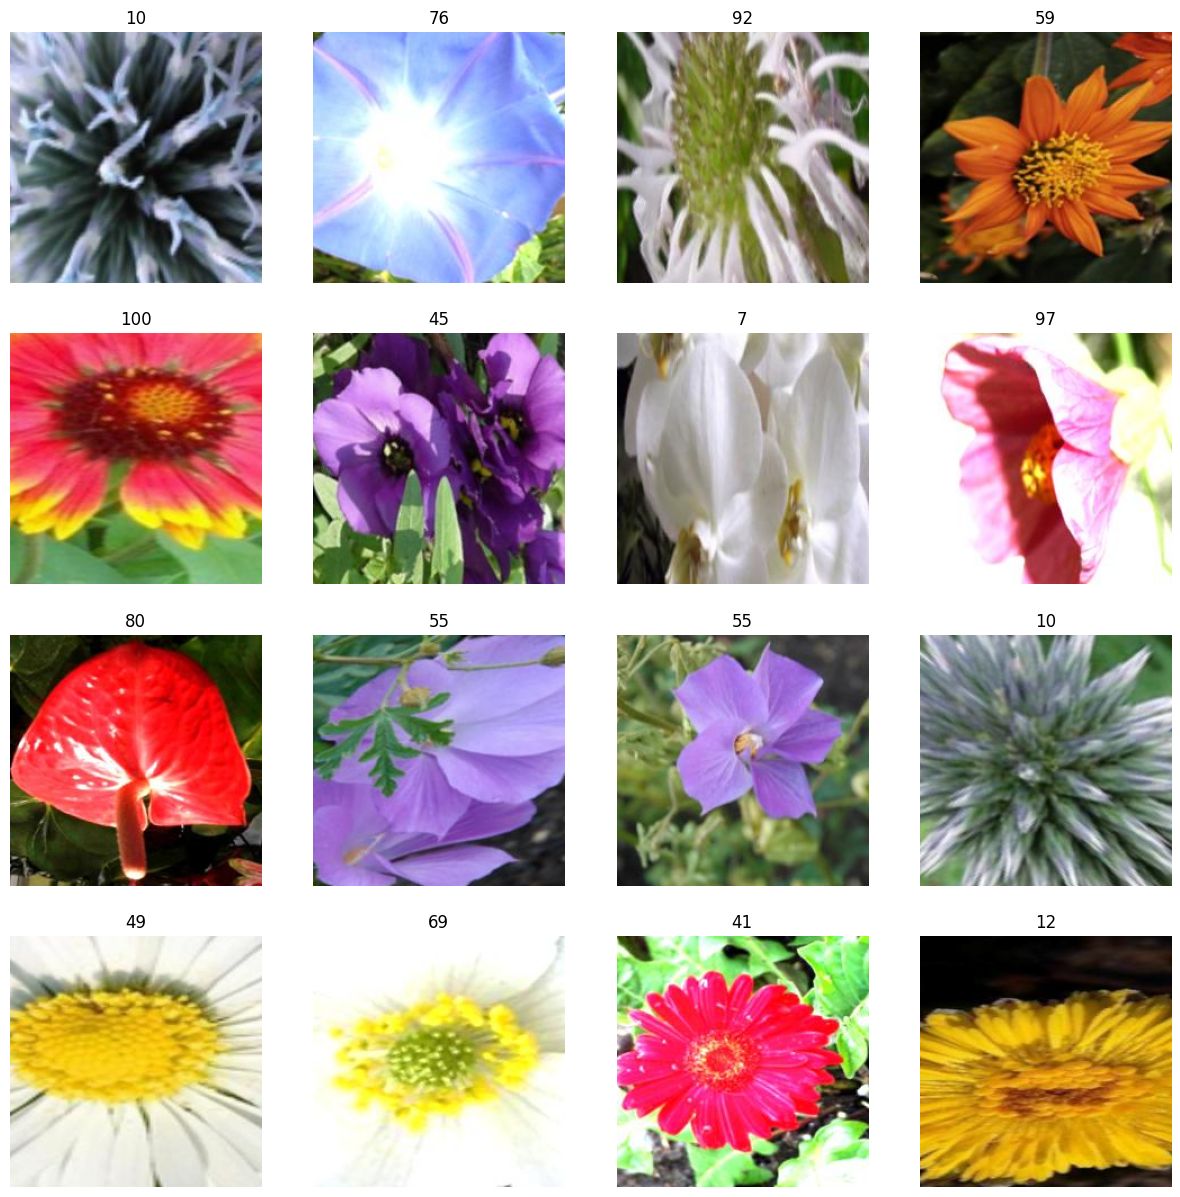

In [37]:
#Plot random samples form the augmented images
plt.figure(figsize=(15, 15))
for i in range(1,17,1):
    ax = plt.subplot(4, 4, i)
    path = random.choice(aug_images)
    image = Image.open(path)
    plt.imshow(np.array(image).astype("uint8"))
    plt.title(path.split('/')[1])
    plt.axis("off")

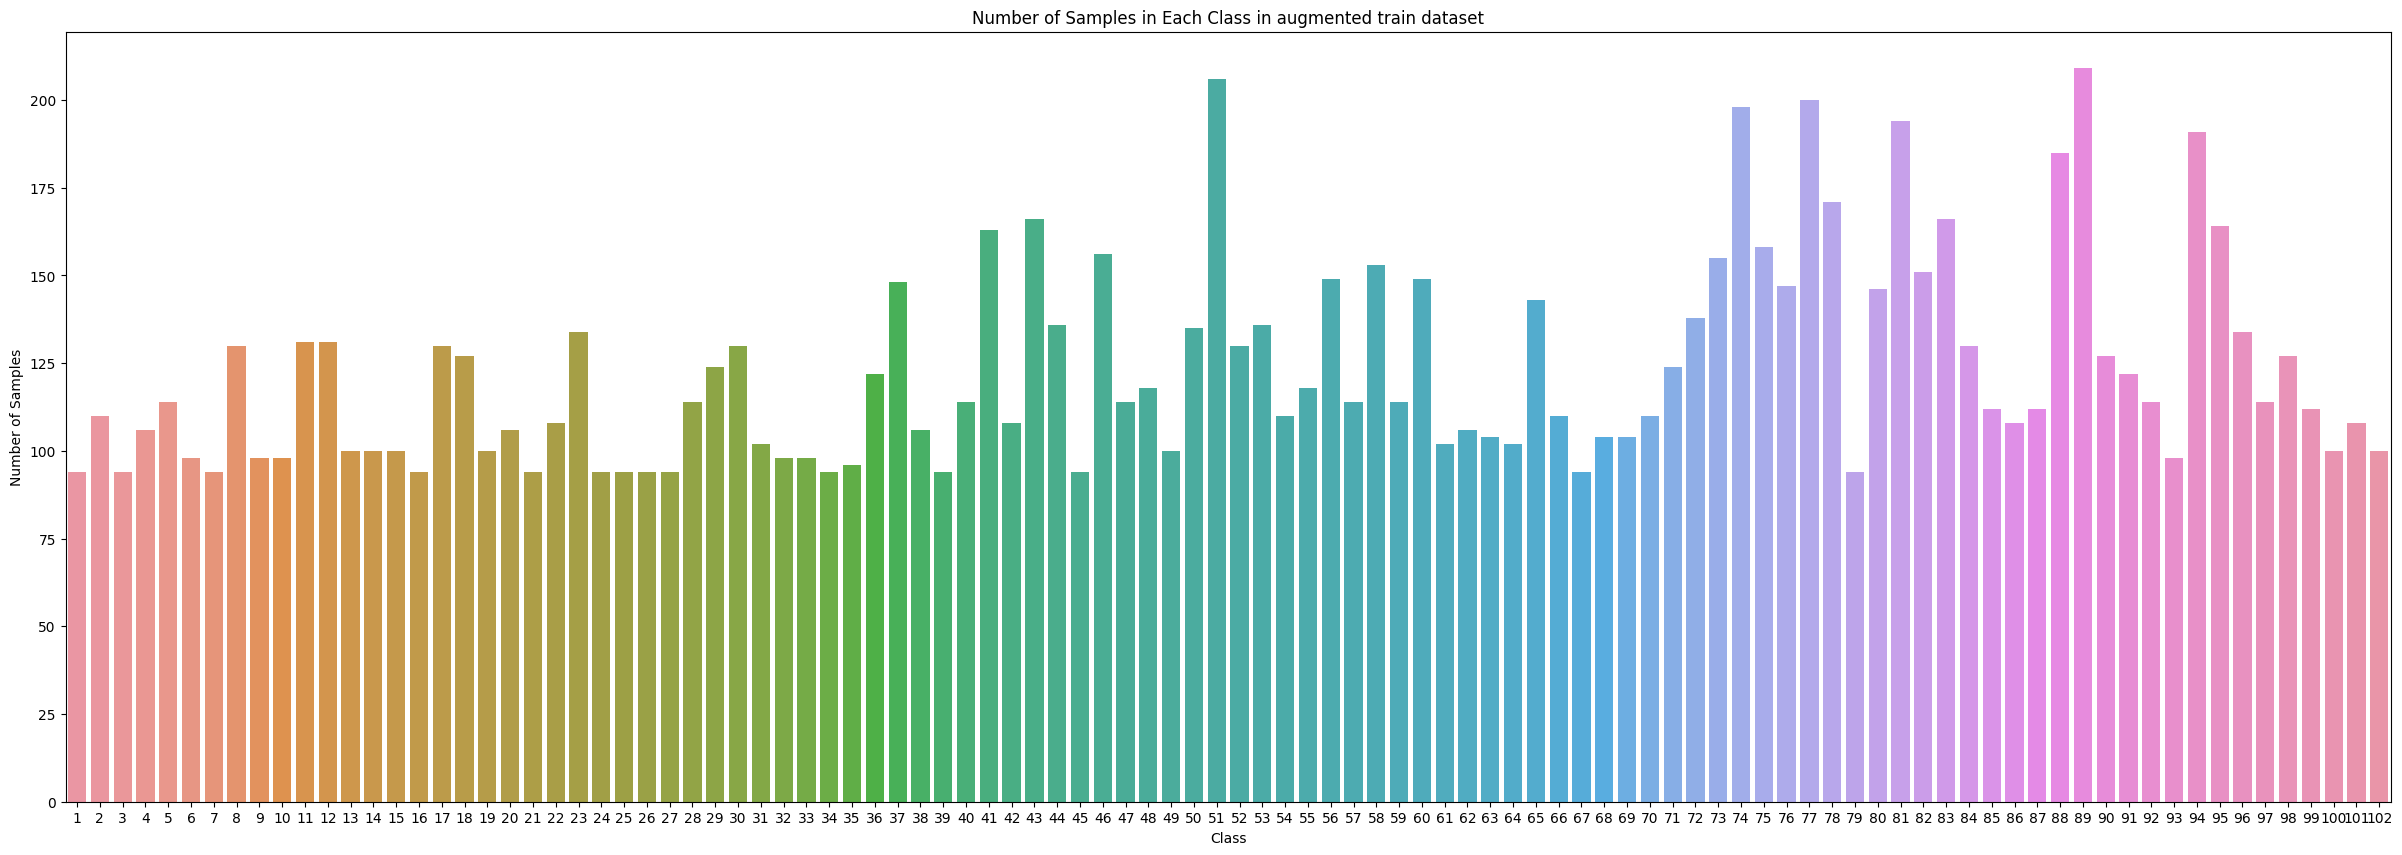

In [38]:
#Check the distribution of the train dataset after augmentation.
train_data={}
for i in range(1,103,1):
  train_data[i] = len(os.listdir('train/'+str(i)))

plot_bar(list(train_data.keys()), list(train_data.values()), 'Class', 'Number of Samples', 'Number of Samples in Each Class in augmented train dataset')

In [39]:
train_aug_generator = datagen.flow_from_directory(train_dir,
                                                  class_mode='categorical',
                                                  batch_size=batch_size,
                                                  target_size=(img_height, img_width))

Found 12564 images belonging to 102 classes.


#**Model 2**

In the previous approache, ResNet50 was used for feature extraction. In this approach, apply fine tunning by retraining some of the ResNet50 layers with a low learning rate.

In [40]:
#Check the number of layers in ResNet50
len(base_model.layers)

175

In [41]:
#Freez the first 170 layers of the model and leave the rest to be retrained.
for layer in base_model.layers[:170]:
   layer.trainable = False

In [42]:
model_2 = Sequential(
    [
        base_model,
        Flatten(),
        Dense(102, activation = 'softmax')
    ]
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 102)               10236006  
                                                                 
Total params: 33823718 (129.03 MB)
Trainable params: 10236006 (39.05 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [43]:
#It is recommended to use low learning rate for fine tunning.
#Set a learning schedule to reduce the learning rate as the training progresses.
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=2e-5,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

In [44]:
model_2.compile(loss='categorical_crossentropy',optimizer=RMSprop(learning_rate=lr_schedule), metrics=['accuracy'])

In [45]:
history_2 = model_2.fit(train_aug_generator,
                        epochs=epochs,
                        verbose=1,
                        validation_data=val_generator)

Epoch 1/25
393/393 [==============================] - 53s 128ms/step - loss: 2.2641 - accuracy: 0.4851 - val_loss: 0.7977 - val_accuracy: 0.7843
Epoch 2/25
393/393 [==============================] - 49s 123ms/step - loss: 0.3375 - accuracy: 0.9056 - val_loss: 0.6047 - val_accuracy: 0.8395
Epoch 3/25
393/393 [==============================] - 48s 121ms/step - loss: 0.0740 - accuracy: 0.9826 - val_loss: 0.5442 - val_accuracy: 0.8554
Epoch 4/25
393/393 [==============================] - 47s 120ms/step - loss: 0.0159 - accuracy: 0.9968 - val_loss: 0.5112 - val_accuracy: 0.8640
Epoch 5/25
393/393 [==============================] - 47s 119ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.4910 - val_accuracy: 0.8750
Epoch 6/25
393/393 [==============================] - 47s 119ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.4815 - val_accuracy: 0.8848
Epoch 7/25
393/393 [==============================] - 50s 126ms/step - loss: 5.5654e-04 - accuracy: 1.0000 - val_loss: 0.4758 - va

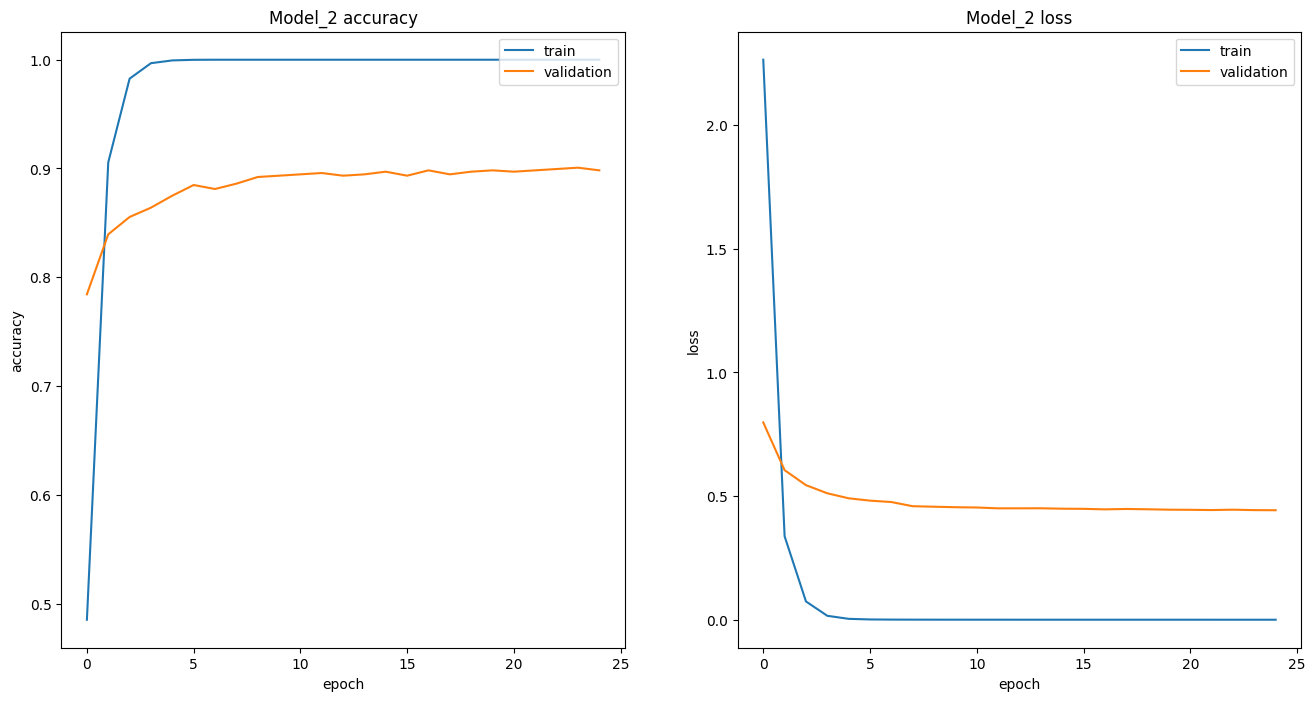

In [46]:
plot_learning_curves(history_2, 'Model_2')

The learning curves show an improved performance and that the model is not suffering from overfitting as there is no increase in the validation loss or decrease in the validation accuracy as the training progressed.

In [47]:
#Predict the labels of validation images
Y_pred2 = model_2.predict(val_generator)
y_pred2 = np.argmax(Y_pred2, axis=1)
val_preds2=[val_dict[k] for k in y_pred2]

26/26 [==============================] - 4s 139ms/step


##**Model 3 Performance Evaluation**

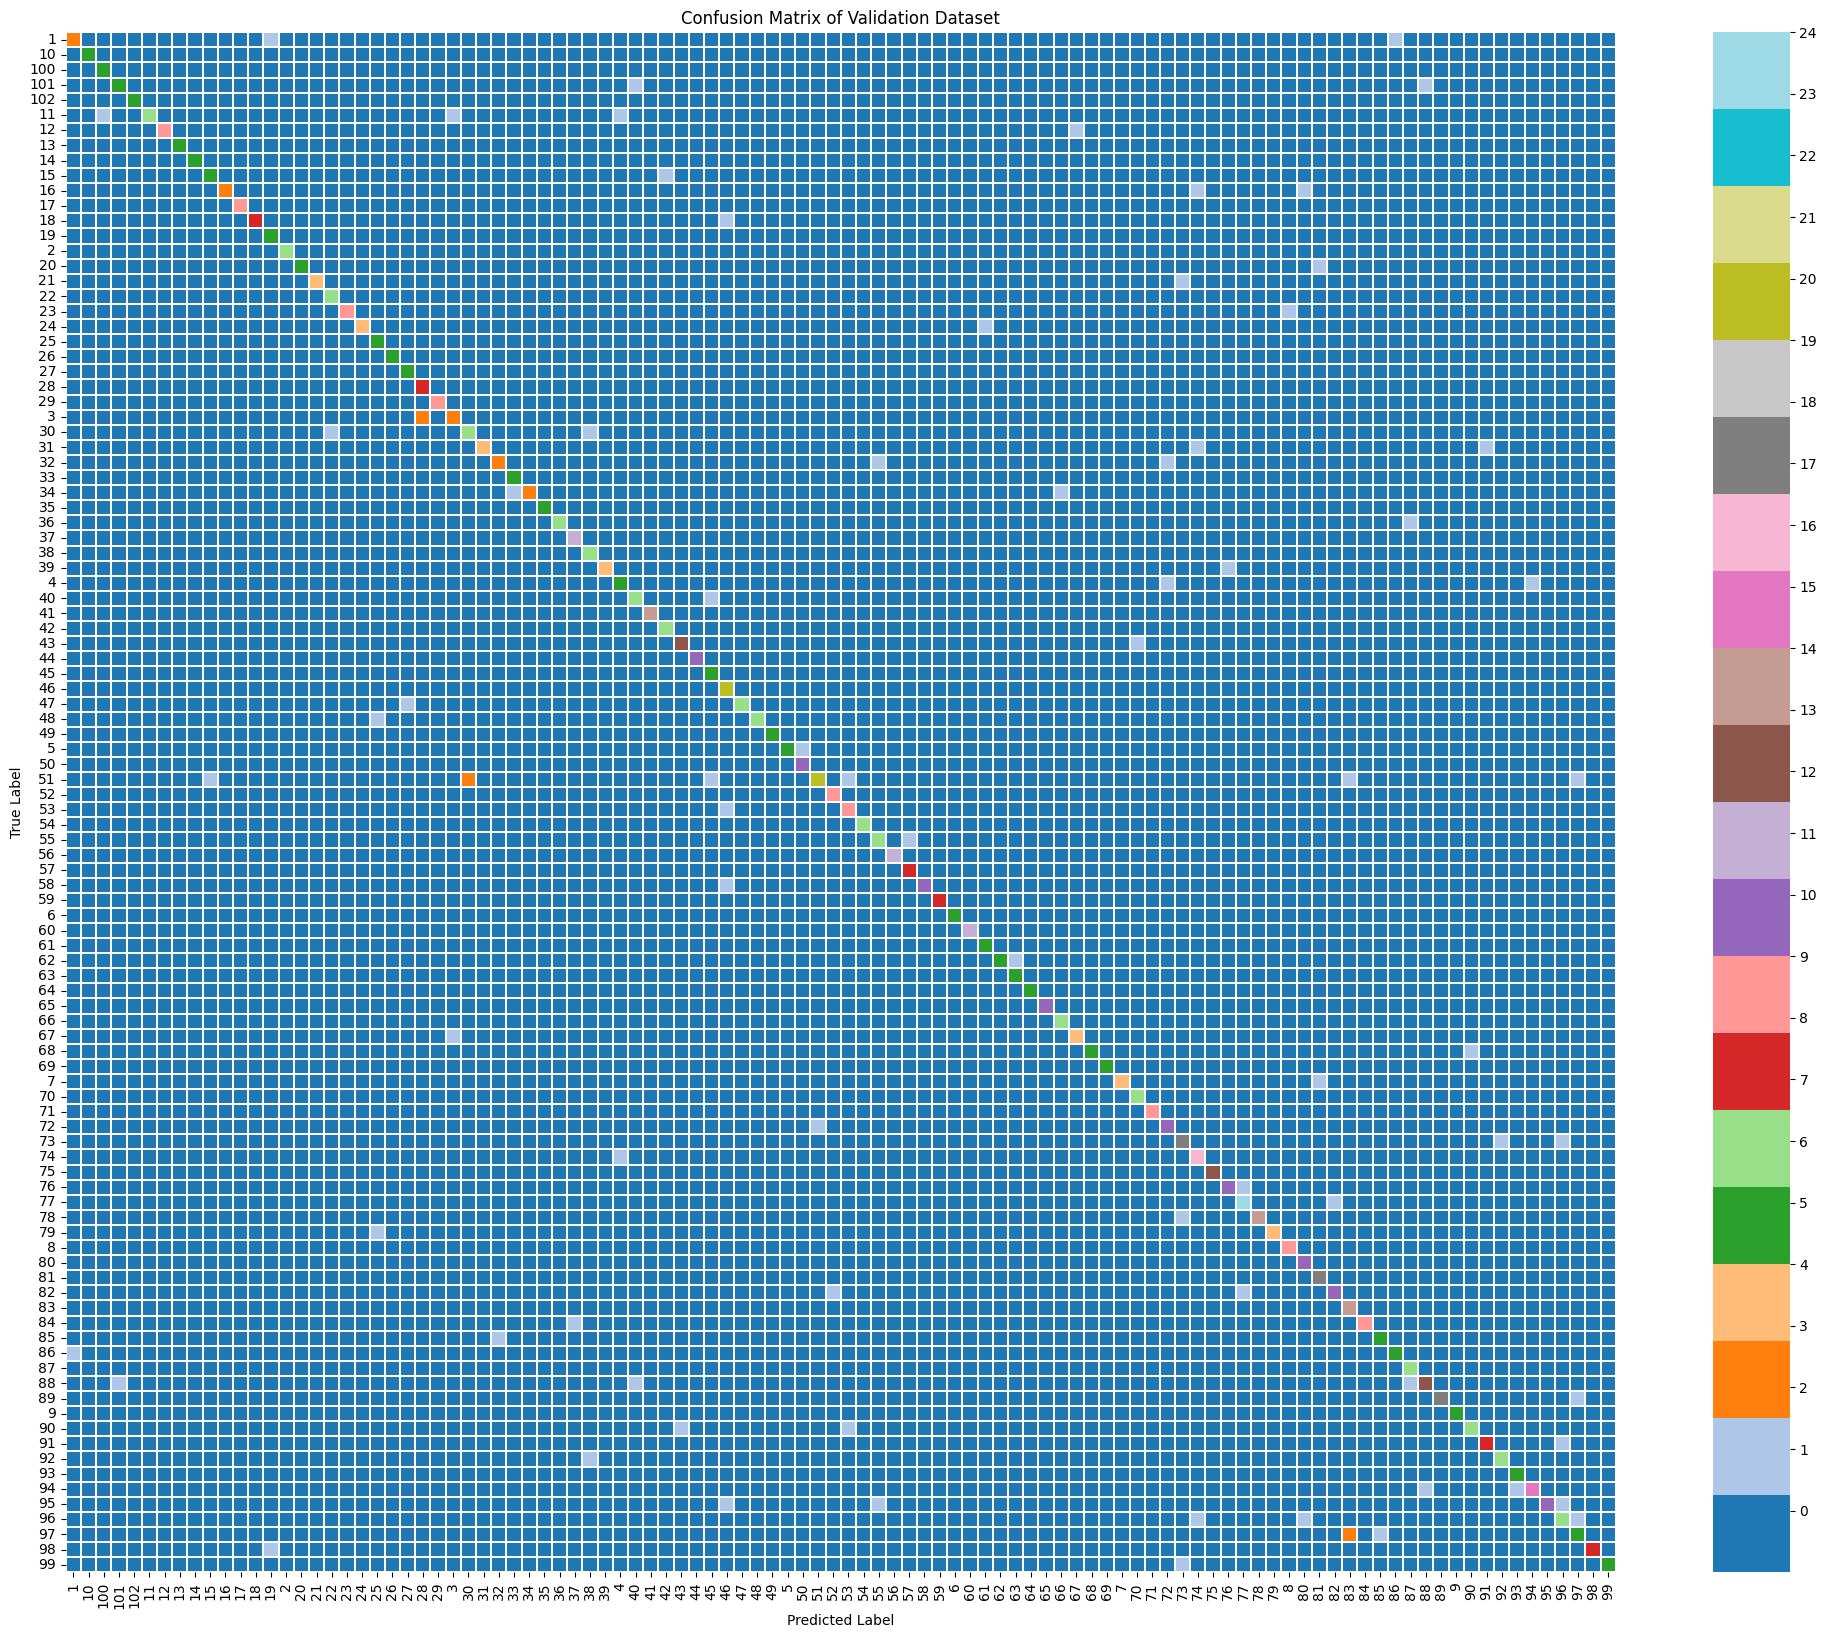

In [48]:
#Plot confusion matrix
confmat = confusion_matrix(val_true,val_preds2)
plt.figure(figsize = (25,20))
confmat_plot=sns.heatmap(confmat, vmin=-1, vmax=np.amax(confmat), cmap=sns.color_palette("tab20", as_cmap=True), linewidths=0.004, cbar_kws={'ticks':range(0,np.amax(confmat)+1,1)}, xticklabels=val_target_names, yticklabels=val_target_names)
confmat_plot.set(xlabel ='Predicted Label', ylabel = 'True Label', title ='Confusion Matrix of Validation Dataset')
plt.show()

In [49]:
print(classification_report(val_true, val_preds2, target_names=val_target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
          10       1.00      1.00      1.00         4
         100       0.83      1.00      0.91         5
         101       0.80      0.67      0.73         6
         102       1.00      1.00      1.00         5
          11       1.00      0.67      0.80         9
          12       1.00      0.89      0.94         9
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       0.80      0.80      0.80         5
          16       1.00      0.50      0.67         4
          17       1.00      1.00      1.00         8
          18       1.00      0.88      0.93         8
          19       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         6
          20       1.00      0.83      0.91         6
          21       1.00      0.75      0.86         4
          22       0.86    

The accuracy of Model_2 on the validation dataset is 90%. The f1_score for Model_2 is 89%. These are much better scores than those of the previous model.

#**Test**

Model_2 showed the best performance, therefore, it is the model of choice.

In [50]:
#Predict the labels of test images
Y_pred = model_2.predict(test_generator)
y_pred_test = np.argmax(Y_pred, axis=1)
y_pred_test

28/28 [==============================] - 3s 119ms/step


array([  0,   0,   0,  49,   1,   1,   1,   1,   1,   2,   2,  77,   2,
         2,   3,   3,  54,   5,   3,   3,   4,   4,   4,   4,   4,   5,
         5,   3,   5,   5,   5,  40,   5,   5,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   7,   7,   7,   7,   7,   8,   8,   8,   8,
         8,   9,   9,   9,   9,   9,  10,  10,  10,  74,  10,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  12,  12,  72,  12,  12,  12,
        12,  72,  12,  13,  13,  13,  13,  13,  14,  14,  14,  14,  14,
        14,  15,  15,  15,  15,  15,  15,  16,  16,  16,  16,  17,  17,
        17,  17,  33,  17,  18,  18,  18,  18,  18,  18,  18,  18,  18,
        10,  19,  19,  19,  19,  19,  20,  20,  17,  20,  20,  21,  21,
        56,  21,  21,  22,  22,  22,  22,  23,  23,  23,  23,  23,  23,
        23,  24,  24,  24,  24,  24,  24,  24,  24,  40,  76,  25,  26,
        27,  26,  26,  26,  72,  26,  26,  26,  26,  27,  19,  27,  27,
        27,  27,  36,  28,  28,  98,  28,  29,  29,  29,  29,  2

In [51]:
#The predictions are onehot encoded.
#Convert the prediction to the labels.
#The labels and their encoding are stored as a dict in the attribute class_indices
test_dict=test_generator.class_indices
test_dict = dict((v,k) for k,v in test_dict.items())
test_preds=[test_dict[k] for k in y_pred_test]
test_true=[test_dict[k] for k in test_generator.classes]

In [52]:
#Get names of classes
test_target_names = list(test_generator.class_indices.keys())

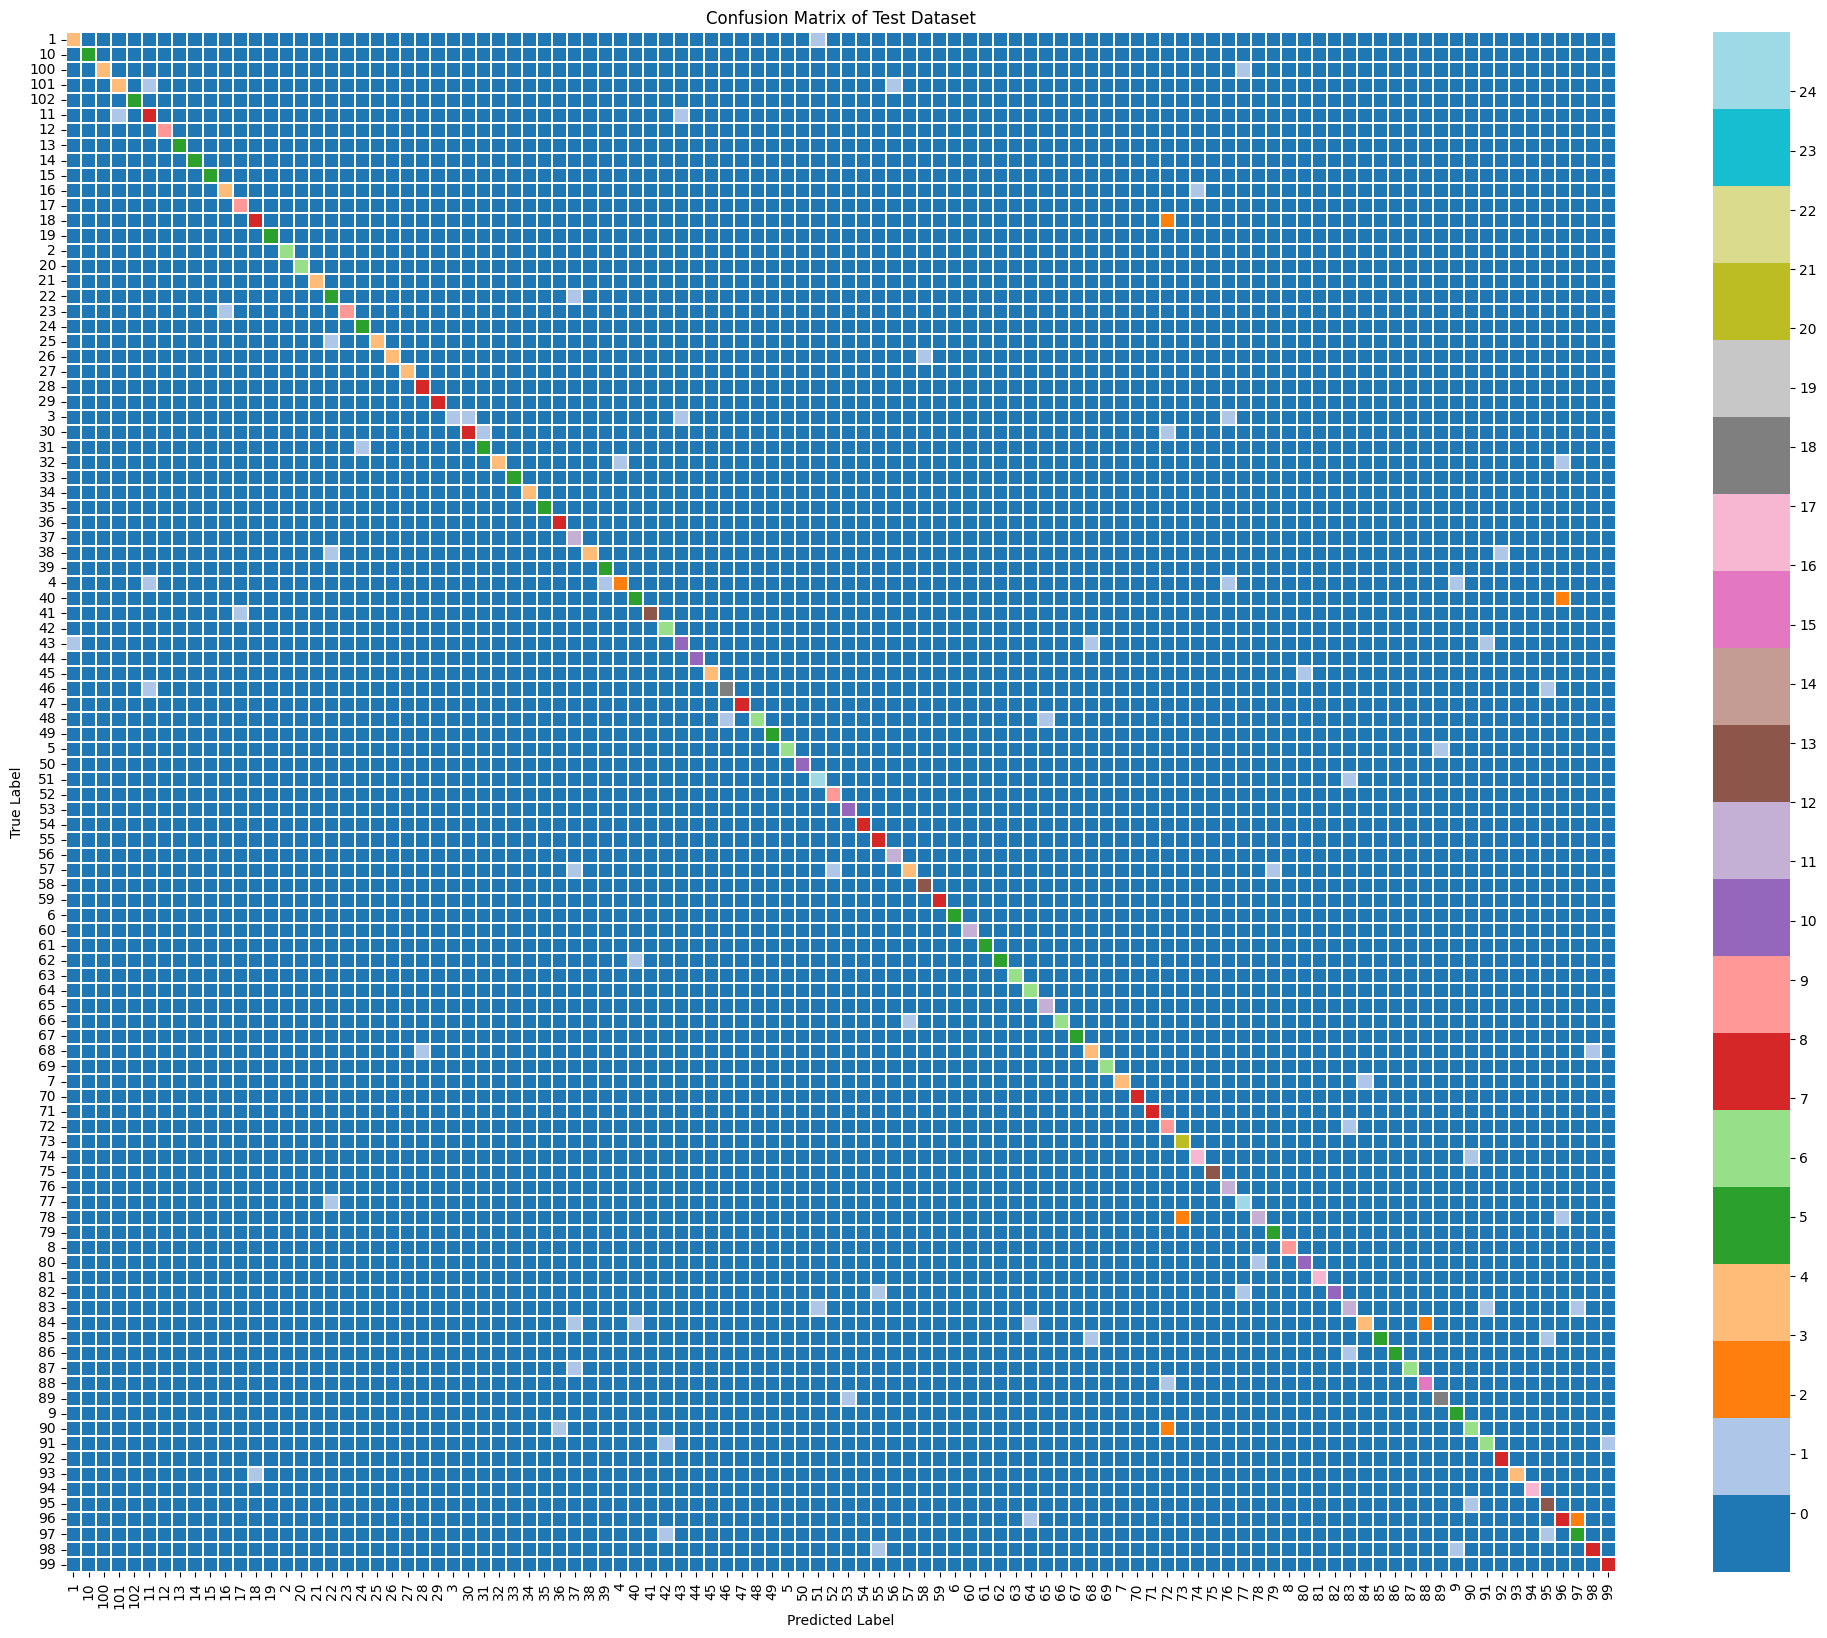

In [53]:
#Plot confusion matrix
test_confmat = confusion_matrix(test_true,test_preds)
plt.figure(figsize = (25,20))
confmat_plot=sns.heatmap(test_confmat, vmin=-1, vmax=np.amax(test_confmat), cmap=sns.color_palette("tab20", as_cmap=True), linewidths=0.004, cbar_kws={'ticks':range(0,np.amax(confmat)+1,1)}, xticklabels=test_target_names, yticklabels=test_target_names)
confmat_plot.set(xlabel ='Predicted Label', ylabel = 'True Label', title ='Confusion Matrix of Test Dataset')
plt.show()

In [54]:
#Print classification report.
print(classification_report(test_true, test_preds, target_names=test_target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
          10       1.00      1.00      1.00         5
         100       1.00      0.80      0.89         5
         101       0.80      0.67      0.73         6
         102       1.00      1.00      1.00         5
          11       0.70      0.78      0.74         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.80      0.80      0.80         5
          17       0.90      1.00      0.95         9
          18       0.88      0.78      0.82         9
          19       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
          20       1.00      1.00      1.00         6
          21       1.00      1.00      1.00         4
          22       0.62    

The accuracy of Model_2 on the test dataset is 90%. The f1_score for Model_2 is 90%.

#**Resources**

These are the recources that helped me solve this challenge.

https://developers.google.com/codelabs/tensorflow-6-largecnns#0

https://meatba11.medium.com/keras-loading-and-processing-images-in-batches-1cff1b0f4aa4

https://www.kaggle.com/general/111208

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

https://www.analyticsvidhya.com/blog/2021/06/offline-data-augmentation-for-multiple-images/

https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay